## Churn Prediction: Hybrid Model with Fallback

This notebook builds on the previous EDA to create a realistic churn prediction pipeline using both structured features and GPT-generated feedback.

The core idea is to develop a **hybrid model**:
- Use structured features when feedback is unavailable
- Leverage textual data (NLP) where available
- Implement **fallback logic** for robustness

This approach mirrors real-world scenarios where customer data is inconsistent or incomplete.


### Telco Customer Churn & GPT Feedback – Notebook Series

We focus on customers who left written feedback, and combine structured features with unstructured text using TF-IDF.  
The goal is to train a **"teacher model"** with maximum predictive power, which will later help improve the fallback system.


We simulate realistic challenges like:
- Partial or missing feedback
- Noisy or irrelevant text
- The need for robust fallback models

Below you'll find where this notebook fits in the overall project:

---

### Project Structure:

1. **Exploring Customer Churn & GPT-generated Feedback**  
   → Data exploration & text insights

2. **Feedback Noise Simulation & Fallback Testing**  
   → Simulate real-world feedback imperfections

3. **Fallback Model – Logistic vs XGB vs RF vs NN**  
   → Structured-only models, compared & evaluated

4. **Model with Feedback – Logistic vs XGB vs NN**  
   → Hybrid modeling using structured + textual data

5. **Prediction using Synthetic Feedback Knowledge**  
   → Transfer feedback model knowledge to fallback model

---

Each notebook builds upon the previous one, leading to a production-ready hybrid solution.


### 📚 Table of Contents

1. [Imports](#imports)  
2. [Loading data](#loading-data)  
3. [Cleaning data](#cleaning-data)  
4. [Correlation matrix](#correlation-matrix)  
5. [Feature Engineering](#feature-engineering)  
6. [Model with Feedback](#model-with-feedback)  
7. [Model without Feedback](#model-without-feedback)  
8. [Mid Summary](#mid-summary)  
9. [Fallback logic](#fallback-logic)  
10. [Final Evaluation: Fallback System](#final-evaluation-fallback-system)<br>
[📦 Notebook Series Overview: Telco Churn & GPT Feedback](#notebook-series-overview-telco-churn--gpt-feedback)


## 1. Imports 
<a id="imports"></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve


import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

## 2. Loading data
<a id="loading-data"></a>


In [2]:
df = pd.read_csv('/kaggle/input/telco-customer-churn-realistic-customer-feedback/telco_churn_with_all_feedback.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,PromptInput,CustomerFeedback
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,Write a realistic customer feedback based on t...,I have been using the DSL internet service fro...
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.5,No,Write a realistic customer feedback based on t...,I have been a customer with this company for o...
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,Write a realistic customer feedback based on t...,I recently signed up for DSL internet service ...
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,Write a realistic customer feedback based on t...,I have been a loyal customer with this company...
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,Write a realistic customer feedback based on t...,I recently switched to this fiber optic intern...


## 3. Cleaning data
<a id="cleaning-data"></a>

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# 'TotalCharges' column was read as object – convert to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [5]:
print(df.isnull().sum())

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
PromptInput          0
CustomerFeedback     0
dtype: int64


>There are only a few nulls so we can drop them.

In [6]:
df = df.dropna()

In [7]:
#Encode 'Churn' column to binary (Yes → 1, No → 0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [8]:
#saving sentiment in separate column
df['feedback_length'] = df['CustomerFeedback'].str.len()
df['sentiment'] = df['CustomerFeedback'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [9]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'PromptInput', 'CustomerFeedback', 'feedback_length', 'sentiment'],
      dtype='object')

In [10]:
df.to_csv("telco_prep.csv")

In [11]:
# Check unique values in all object-type (categorical) columns
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Strip whitespace and lowercase categorical columns
for col in categorical_cols:
    df[col] = df[col].str.strip().str.lower()

for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")
    print(df[col].unique())
    print("-----")

customerID: 7032 unique values
['7590-vhveg' '5575-gnvde' '3668-qpybk' ... '0575-cuqov' '0967-bmlbd'
 '6178-kfnhs']
-----
gender: 2 unique values
['female' 'male']
-----
Partner: 2 unique values
['yes' 'no']
-----
Dependents: 2 unique values
['no' 'yes']
-----
PhoneService: 2 unique values
['no' 'yes']
-----
MultipleLines: 3 unique values
['no phone service' 'no' 'yes']
-----
InternetService: 3 unique values
['dsl' 'fiber optic' 'no']
-----
OnlineSecurity: 3 unique values
['no' 'yes' 'no internet service']
-----
OnlineBackup: 3 unique values
['yes' 'no' 'no internet service']
-----
DeviceProtection: 3 unique values
['no' 'yes' 'no internet service']
-----
TechSupport: 3 unique values
['no' 'yes' 'no internet service']
-----
StreamingTV: 3 unique values
['no' 'yes' 'no internet service']
-----
StreamingMovies: 3 unique values
['no' 'yes' 'no internet service']
-----
Contract: 3 unique values
['month-to-month' 'one year' 'two year']
-----
PaperlessBilling: 2 unique values
['yes' 'no']
--

>Summary: No typos or duplicated categories

## 4. Correlation matrix
<a id="correlation-matrix"></a>

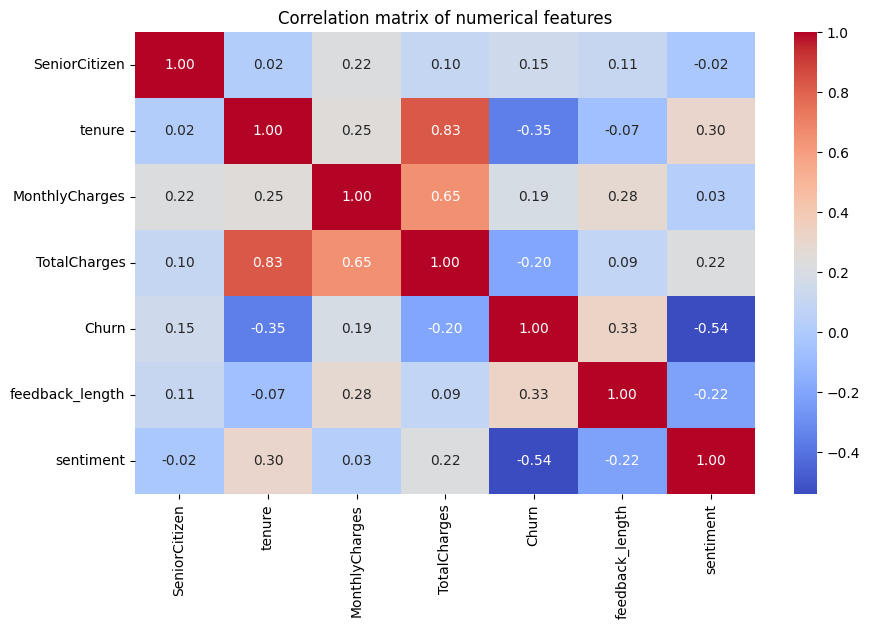

In [12]:
# Select only numerical features
num_corr = df.select_dtypes(include=['float64', 'int64'])

# Compute and plot correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(num_corr.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation matrix of numerical features")
plt.show()


### Correlation Matrix Summary

- `tenure` and `TotalCharges` show a moderate positive correlation (0.65), which is expected: longer-tenure customers accumulate higher total charges.
- `MonthlyCharges` is weakly correlated with `TotalCharges` (0.35) and `tenure` (0.28), suggesting these features capture slightly different aspects of customer behavior.
- `feedback_length` and `sentiment` are moderately correlated with `Churn` (0.38 and -0.52 respectively), indicating that the tone and length of customer feedback may help predict churn.
- `Churn` has a weak negative correlation with `tenure` (-0.35), consistent with the idea that new customers are more likely to leave.
- `SeniorCitizen` shows no strong correlation with any variable.


## 5. Feature Engineering
<a id="feature-engineering"></a>


### Feature selection

We selected the following variables:

- `Contract`, `InternetService`, `PaymentMethod` – core subscription characteristics
- `tenure`, `MonthlyCharges`, `TotalCharges` – key behavioral and financial indicators
- `CustomerFeedback` – qualitative insight via TF-IDF
- `feedback_length`, `sentiment` – quantitative summary of text

These are interpretable, domain-relevant, and capture both structured and unstructured information.


## 6. Model with all Feedback
<a id="model-with-feedback"></a>

In [13]:
# Define feature categories
# text columns
# numerical columns
# categorical columns

text_col = 'CustomerFeedback'
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges', 'feedback_length', 'sentiment']
categorical_features = ["Contract", "PaymentMethod", "InternetService", "Partner", "Dependents"]

In [14]:
# Preprocessing for each type of feature

# 1. TF-IDF vectorizer for feedback text (limit to 100 words for speed)
text_transformer = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=100))
])

# 2. Standard scaler for numerical features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# 3. One-hot encoder for categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [15]:
# Combine all preprocessing steps
preprocessor = ColumnTransformer(transformers=[
    ('text', text_transformer, text_col),
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

### Train Test split

In [16]:
# Define features and label
X = df[[text_col] + numeric_features + categorical_features]
y = df['Churn']

# 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Train model

In [17]:
# Logistic Regression pipeline
model_1 = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
model_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=100))]),
                                                  'CustomerFeedback'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges',
                                                   'feedback_length',
                                                   'sentiment']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Contract', 'PaymentMethod',
                                                   'InternetService', 'Partner',
                                                   'Dependents'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

### Evaluation

In [18]:
# Predictions
y_pred = model_1.predict(X_test)
y_prob = model_1.predict_proba(X_test)[:, 1]

# Classification metrics
print(classification_report(y_test, y_pred))

# AUC score
roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {roc_auc:.4f}")


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1033
           1       1.00      0.99      1.00       374

    accuracy                           1.00      1407
   macro avg       1.00      1.00      1.00      1407
weighted avg       1.00      1.00      1.00      1407

ROC AUC: 1.0000


### 🔴 The result give us a red flag! ⚠️ Model is overfitting or there is some feature leakage.

>Checking model without customerfeedback


## 7. Model without Feedback
<a id="model-without-feedback"></a>


In [19]:
# Define feature sets
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = ["Contract", "PaymentMethod", "InternetService", "Partner", "Dependents"]

preprocessor_no_text = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


In [20]:
# Split
X_no_text = df[numeric_features + categorical_features]
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X_no_text, y, stratify=y, test_size=0.2, random_state=42
)

# Fit model
model_no_text = Pipeline([
    ('preprocessing', preprocessor_no_text),
    ('classifier', LogisticRegression(max_iter=1000))
])
model_no_text.fit(X_train, y_train)

# Evaluate
y_pred_all = model_no_text.predict(X_test)
y_prob_all = model_no_text.predict_proba(X_test)[:, 1]

fpr_all, tpr_all, _ = roc_curve(y_test, y_prob_all)
auc_all = roc_auc_score(y_test, y_prob_all)
print(classification_report(y_test, y_pred_all))
print("ROC AUC:", roc_auc_score(y_test, y_prob_all))


              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1033
           1       0.65      0.50      0.57       374

    accuracy                           0.80      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.79      0.80      0.79      1407

ROC AUC: 0.8403267053543234


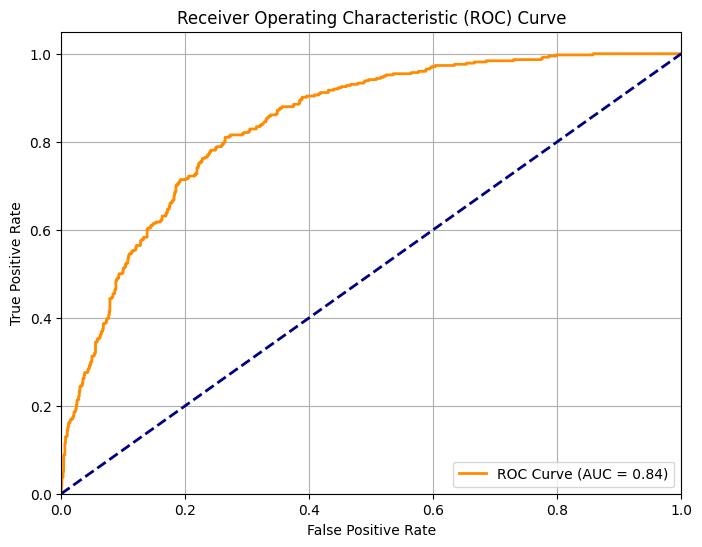

In [21]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_all, tpr_all, label=f"ROC Curve (AUC = {auc_all:.2f})", color="darkorange", lw=2)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


## **Mid Summary**
<a id="mid-summary"></a>

### Model Performance Summary: With vs Without Customer Feedback

The comparison between the two models highlights the importance of critical evaluation when working with high-performing classifiers — especially in the presence of synthetic or potentially overfitted data.

---

#### **1. Model with Customer Feedback**

* **Accuracy**: 1.00
* **ROC AUC**: 1.00
* **F1-Score (Churn)**: 1.00

> While these results may seem impressive, they raise serious concerns about overfitting. A perfect score in both accuracy and ROC AUC is extremely rare in real-world data.
> It is likely that the model is either:
>
> * Memorizing patterns in the feedback (e.g., keywords unique to churned customers)
> * Benefiting from artifacts in GPT-generated text that inadvertently reveal the churn label

---

#### **2. Model without Customer Feedback**

This baseline model was trained using only structured customer data — such as tenure, monthly charges, and contract type — without incorporating any information derived from customer feedback.


* **Accuracy**: 0.80

* **ROC AUC**: 0.84

* **F1-Score (Churn)**: 0.57

* **Recall (Churn)**: 0.51

>
The model performs reasonably well overall, achieving 80% accuracy and a solid ROC AUC of 0.84.
>However, it struggles to identify churned customers, with a relatively low recall of 51% and F1-score of 0.57 for the churn class.
>This suggests that structured features alone may not be sufficient to fully capture churn risk, particularly for borderline or behavior-driven cases.

**The performance gap highlights the potential value of feedback-based features, which may contain emotional or contextual signals not captured in transactional data.**




---

In real-world scenarios, not all customers provide feedback. To simulate this, we split our dataset into:
- Customers who left realistic feedback (`has_feedback == True`)
- Customers without feedback (`has_feedback == False`)

We then train and evaluate models on both subsets to understand the impact of customer feedback on churn prediction.


## 8. Simulate 'Has Feedback'

In [22]:
np.random.seed(42)

# Randomly assign 25% of rows to have feedback
df["HasFeedback"] = np.random.rand(len(df)) < 0.25

# === SUMMARY TABLE ===
feedback_counts = (
    df["HasFeedback"]
    .value_counts()
    .rename(index={True: "Has Feedback", False: "No Feedback"})
    .to_frame(name="count")
)
feedback_counts["percentage"] = (feedback_counts["count"] / len(df) * 100).round(2)

print("📊 Feedback availability (simulated):")
print(feedback_counts)

# === SAVE COPY ===
df_simulated = df.copy()


📊 Feedback availability (simulated):
              count  percentage
HasFeedback                    
No Feedback    5228       74.35
Has Feedback   1804       25.65


In [23]:
# Comparison of Churn distribution for two groups: with and without feedback
churn_distribution = df_simulated.groupby("HasFeedback")["Churn"].value_counts(normalize=True).unstack().round(3)
churn_distribution.columns = ['No Churn (0)', 'Churn (1)']
print(churn_distribution)

             No Churn (0)  Churn (1)
HasFeedback                         
False               0.731      0.269
True                0.743      0.257


>Churn distribution is very similar in both groups (~1% difference), <br>
>So the drop in quality of the model without feedback is not due to a different target distribution <br>
>It is probably due to a smaller amount of information (e.g. lack of sentiment, lack of text length, lack of additional context) <br>

## 9. Fallback logic
<a id="fallback-logic"></a>

In [25]:
# ==== CONFIGURATION ====
text_col = "CustomerFeedback"
num_base = ['tenure', 'MonthlyCharges', 'TotalCharges']
num_with_text = num_base + ['feedback_length', 'sentiment']
cat_cols = ["Contract", "PaymentMethod", "InternetService", "Partner", "Dependents"]
target_col = 'Churn'

# ==== TRANSFORMERS ====
num_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])
txt_transformer = Pipeline([('tfidf', TfidfVectorizer(max_features=100))])

# ==== DATA SPLITTING ====
df_fb = df[df["HasFeedback"]].copy()
df_nofb = df[~df["HasFeedback"]].copy()

X_fb = df_fb[num_with_text + cat_cols + [text_col]]
y_fb = df_fb[target_col]

X_nofb = df_nofb[num_base + cat_cols]
y_nofb = df_nofb[target_col]

# ==== MODEL WITH FEEDBACK ====
preprocessor_with_text = ColumnTransformer([
    ('num', num_transformer, num_with_text),
    ('cat', cat_transformer, cat_cols),
    ('txt', txt_transformer, text_col)
])

model_with_text = Pipeline([
    ('preprocessing', preprocessor_with_text),
    ('classifier', LogisticRegression(max_iter=1000))
])

model_with_text.fit(X_fb, y_fb)

# ==== MODEL WITHOUT FEEDBACK ====
model_fallback = Pipeline([
    ('preprocessing', preprocessor_no_text),
    ('classifier', LogisticRegression(max_iter=1000))
])
model_fallback.fit(X_nofb, y_nofb)

# ==== PREDICT & COMBINE ====
preds_fb = model_with_text.predict(X_fb)
probs_fb = model_with_text.predict_proba(X_fb)[:, 1]

preds_nofb = model_fallback.predict(X_nofb)
probs_nofb = model_fallback.predict_proba(X_nofb)[:, 1]

y_true_combined = pd.concat([y_fb, y_nofb])
y_pred_combined = np.concatenate([preds_fb, preds_nofb])
y_prob_combined = np.concatenate([probs_fb, probs_nofb])


fpr_fb, tpr_fb, _ = roc_curve(y_fb, probs_fb)
auc_fb = roc_auc_score(y_fb, probs_fb)


fpr_combined, tpr_combined, _ = roc_curve(y_true_combined, y_prob_combined)
auc_combined = roc_auc_score(y_true_combined, y_prob_combined)

# Evaluation
report_combined = classification_report(y_true_combined, y_pred_combined, output_dict=True)
roc_auc_combined = roc_auc_score(y_true_combined, y_prob_combined)


results_combined = pd.DataFrame(report_combined).transpose()
results_combined["roc_auc"] = roc_auc_combined

print(results_combined)


              precision    recall  f1-score     support   roc_auc
0              0.880037  0.922138  0.900596  5163.00000  0.908856
1              0.752158  0.652755  0.698940  1869.00000  0.908856
accuracy       0.850540  0.850540  0.850540     0.85054  0.908856
macro avg      0.816097  0.787447  0.799768  7032.00000  0.908856
weighted avg   0.846049  0.850540  0.846999  7032.00000  0.908856


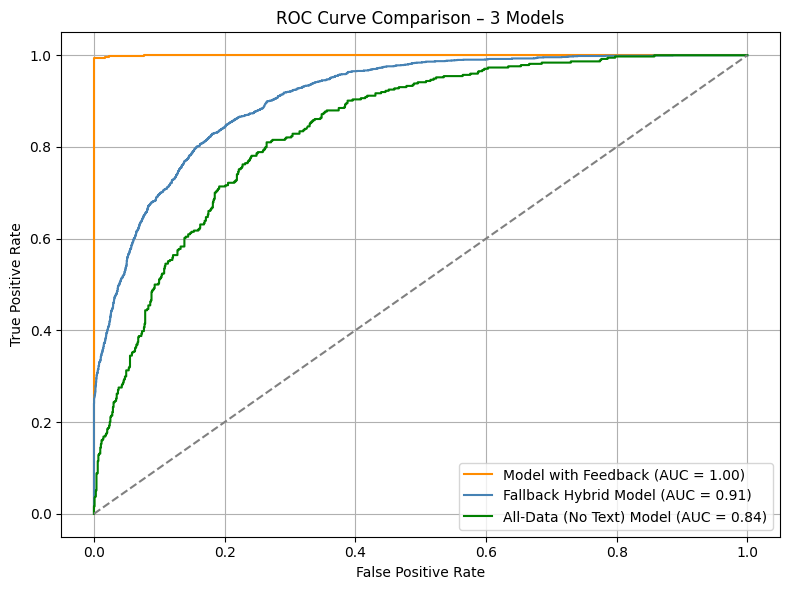

In [26]:
plt.figure(figsize=(8, 6))


plt.plot(fpr_fb, tpr_fb, label=f"Model with Feedback (AUC = {auc_fb:.2f})", color="darkorange")
plt.plot(fpr_combined, tpr_combined, label=f"Fallback Hybrid Model (AUC = {auc_combined:.2f})", color="steelblue")
plt.plot(fpr_all, tpr_all, label=f"All-Data (No Text) Model (AUC = {auc_all:.2f})", color="green")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison – 3 Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


## 10. Final Evaluation: Fallback System
<a id="final-evaluation-fallback-system"></a>



In a real-world scenario, not all customers leave textual feedback. To address this, we simulated a production-ready fallback system:

- If feedback is available → we use a powerful model with TF-IDF, sentiment, and feedback length
- If not → we fall back to a simpler model trained only on numeric and categorical features

#### Results:

- **Fallback system AUC:** 0.91
- **Precision (churn):** 0.75
- **Recall (churn):** 0.66
- **F1-score (churn):** 0.70

🔹 The model performs especially well at identifying non-churned customers (precision: 0.88, recall: 0.92) <br>
🔸 While performance is slightly lower on churned customers (precision: 0.75, recall: 0.66), it remains strong enough to drive actionable insights

This confirms that combining structured features with fallback logic (for missing or noisy feedback) produces a robust and deployable solution for churn prediction in real-life settings.
This approach balances performance and realism, providing strong accuracy while simulating how feedback availability affects predictive power.


## 📁 Notebook Series Overview: **Telco Churn & GPT Feedback**
<a id="notebook-series-overview-telco-churn--gpt-feedback"></a>

This is part of a multi-notebook series focused on **realistic churn prediction** using structured data and GPT-generated customer feedback.  
We simulate real-world challenges such as missing text, noisy input, and model fallback logic — building toward a robust, production-style solution.

---

###  1. Exploring Customer Churn & GPT-generated Feedback

> Exploratory analysis of the churn dataset, with focus on customer segments, behavior patterns, and text feedback characteristics.  
> Text insights powered by GPT-generated responses.

---

###  2. Feedback Noise Simulation & Fallback Testing

> We simulate feedback imperfections (irrelevant, incomplete, or missing entries) and measure how models perform under noise.  
> Introduces the concept of fallback systems for low-signal situations.

---

### 3. Fallback Model – Logistic vs XGB vs RF vs NN

> We train and compare multiple classifiers on **structured-only data** (no feedback):  
> Logistic Regression, Random Forest, XGBoost, and Neural Net.  
> Best fallback model is selected based on ROC AUC and recall.

---

###  4. Model with Feedback – Logistic vs XGB vs NN

> We focus on customers who left written feedback.  
> Structured data is combined with TF-IDF vectors to train a stronger “teacher” model.  
> Logistic Regression emerges as the most interpretable and best-performing solution.

---

### 5. Prediction using Synthetic Feedback Knowledge

> Even when customers don’t leave feedback, we simulate its predictive signal using the trained teacher model.  
> We generate a `synthetic_text_score` and evaluate whether it helps fallback performance.

---


---
**Author:** Beata Faron  
[LinkedIn](https://www.linkedin.com/in/beata-faron-24764832/) • [Kaggle](https://www.kaggle.com/beatafaron)

*Data Scientist with a background in business, design, and machine learning. Focused on time series forecasting and real-world applications.*
